In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
from collections import OrderedDict #sorting participant df dict before pd.concat()
import matplotlib.pylab as plt
%matplotlib inline
pd.options.display.mpl_style = 'default'

TASK_NAMES_USING = [
                  'T1_SMS_5',       'T1_SMS_8', 
                  'Ticks_ISO_T2_5', 'Ticks_ISO_T2_8',
                  'Ticks_Linear_5', 'Ticks_Linear_8',
                  'Ticks_Phase_5',  'Ticks_Phase_8',
                  'Jits_ISO_5',     'Jits_ISO_8',
                  'Jits_Phase_5',   'Jits_Phase_8',            
                  'Jits_Linear_5',  'Jits_Linear_8',
                  'ISIP_5',         'ISIP_8', 
                  'Improv_Metronome',
                  'Improv_Melody',     
                  ]

pid_exclusions = {k: [] for k in TASK_NAMES_USING}

REMOVE_TASKS = ['Ticks_Pract_8', 'Ticks_Pract_5', 
                    'Practice_Tick_8', 'Practice_Tick_5',
                    'Jits_Pract_8', 'Jits_Pract_5',
                    'Practice_jittr_8', 'Practice_jittr_5',
                    'Pattern_Practice', ]

PRACTICE_TASK_NUMBERS = [0, 1, 11, 24, 25]
PITCH_R_PAD = 48
PITCH_L_PAD = 38
#PITCH_TICK = 42

CHANNEL_TAP = 1
CHANNEL_PIANO = 2
CHANNEL_LOOPBACK = 5

In [2]:
#EXPECTED_LOOPBACK_COUNTS = {
#    'T1_SMS_5': 130,
#    'T1_SMS_8': 120,
#    'Ticks_ISO_T2_5': 130,
#    'Ticks_ISO_T2_8': 120,
#    'Ticks_Linear_5': 170,
#    'Ticks_Linear_8': 170,
#    'Ticks_Phase_5': 170,
#    'Ticks_Phase_8': 170,
#    'Jits_ISO_5': 360,
#    'Jits_ISO_8': 360,
#    'Jits_Phase_5': 510,
#    'Jits_Phase_8': 510,
#    'Jits_Linear_5': 510,
#    'Jits_Linear_8': 510,
#    'ISIP_5': 40,
#    'ISIP_8': 30,
#    'Improv_Metronome': 140,
#    'Improv_Melody': 162,
#    }

In [3]:
def participant_df(csvfilename):
    '''
    clean up some of the raw CSVs' idiosyncracies 
    and load into a one-participant DataFrame.
    '''
    import os  #getting csv file paths
    from StringIO import StringIO
    csv_lines = open(csvfilename).readlines()
    csv_edited = ('csv_line,stamp_type,' +
                  'run_count,task_id,task_name,i,channel,pitch,velocity,micros,blank' + 
                  '\n')
    for idx, line in enumerate(csv_lines):
        # Lines not to parse: per-task headings, end markers, non-timestamped targets
        # (silent, unused targets in ISIP timestamped micros=0 in early admin software version)
        if any(s in line for s in ['[', 'taskRunCount', 'end,end,end', 'IntervalOut,X,X,0']):
            continue
        line_number = str(idx)
        if ('IntervalOut' in line):
            stamp_type = 'target' 
            line = line.replace('X,', ',')    
            line = line.replace('IntervalOut,', ',')
        else:
            stamp_type = 'midi' #this doesn't distinguish between performance (ch1) and loopback (ch5)
                                #...let alone left/right tap!
        csv_edited += (line_number + ',' + 
                       stamp_type + ',' +
                       line)
    df = pd.read_csv(StringIO(csv_edited), 
                 index_col = ['task_name','csv_line'], #was taskname, stamp_type, csvline
                 header = 0,  
                 )
    df = df.drop('blank', axis=1)
    return df

In [4]:
#list files in subdir that end in .csv
import os

path = './csv_raw_data'
allfiles = os.listdir(path)
csvfiles = [os.path.join(path, f) 
            for f in list(allfiles) 
            if os.path.splitext(f)[1]==".csv"]

#something fails at this point when running on Wakari 
#(so, maybe any linux platform?) - the file names are correct,
# but participant_df(f) returns blank dataframes.
sub_dfs = {os.path.basename(f)[3:6]: participant_df(f) 
           for f in csvfiles}
sub_dfs_sorted = OrderedDict(sorted(sub_dfs.items(), key=lambda t: t[0]))

dbase = pd.concat(sub_dfs_sorted.values(), 
                  #axis=0, #defaults
                  #join='outer', 
                  #join_axes=None, 
                  #ignore_index=False, 
                  keys=sub_dfs_sorted.keys(),  # participant id strings
                  #levels=None, 
                  names=['pid'], 
                  #verify_integrity=False
                  )

In [5]:
for t in REMOVE_TASKS:
    dbase = dbase.drop(REMOVE_TASKS, axis=0, level='task_name')
    
pid_list = sorted(list(dbase.index.get_level_values('pid').unique()))
print(pid_list)
task_name_list = sorted(list(dbase.index.get_level_values('task_name').unique()))
print(task_name_list)

['015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121']
['ISIP_5', 'ISIP_8', 'Improv_Melody', 'Improv_Metronome', 'Jits_ISO_5', 'Jits_ISO_8', 'Jits_Linear_5', 'Jits_Linear_8', 'Jits_Phase_5', 'Jits_Phase_8', 'Pattern_Record', 'T1_SMS_5', 'T1_SMS_8', 'Ticks_ISO_T2_5', 'Ticks_ISO_T2_8', 'Ticks_Linear_5', 'T

In [6]:
# promote task_name above pid to top of index hierarchy
dbase = dbase.swaplevel(0,1, axis=0) 
dbase = dbase.sort()
#This puts the tasks in alphabetical order, but we'll need to get the original
#task presentation order eventually. Can't use run_count easily (because it 
#goes back to 1 if the machine was reset), but we could compare the 
#min(csv_line) for each task, since that doesn't reset.

dbase.loc[(dbase.channel==CHANNEL_TAP) & (dbase.pitch==PITCH_R_PAD), 'stamp_type'] = 'tap_r'
dbase.loc[(dbase.channel==CHANNEL_TAP) & (dbase.pitch==PITCH_L_PAD), 'stamp_type'] = 'tap_l'
dbase.loc[(dbase.channel==CHANNEL_TAP) 
          & (dbase.pitch != PITCH_L_PAD) 
          & (dbase.pitch != PITCH_R_PAD), 'stamp_type'] = 'tap_trigger_error'
dbase.ix[dbase.channel==CHANNEL_PIANO, 'stamp_type'] = 'piano'
dbase.ix[dbase.channel==CHANNEL_LOOPBACK, 'stamp_type'] = 'loopback'

assert set(dbase.stamp_type.values) == set(['loopback', 'piano', 'tap_r', 
                                            'tap_l', 'tap_trigger_error', 
                                            'target'])

In [7]:
# removing duplicate tasks manually from CSV files-- running out of memory
# while trying to do this in pandas (below)

#grouped = dbase.groupby(level=['task_name', 'pid'])
#
#def select_rerun_tasks(df):
#    trc_min = df.run_count.min()
#    trc_max = df.run_count.max()    
#    df['trc_min'] = trc_min
#    df['trc_max'] = trc_max    
#    subset = df.loc[df.trc_min != df.trc_max]
#    return subset
#
#db_duplicate_issues = grouped.apply(select_rerun_tasks)
#
#dbdi = db_duplicate_issues.loc[(db_duplicate_issues.stamp_type=='loopback')
#                                & (db_duplicate_issues.task_id != PRACTICE_TASK_NUMBERS[0])
#                                & (db_duplicate_issues.task_id != PRACTICE_TASK_NUMBERS[1])
#                                & (db_duplicate_issues.task_id != PRACTICE_TASK_NUMBERS[2])
#                                & (db_duplicate_issues.task_id != PRACTICE_TASK_NUMBERS[3])
#                                & (db_duplicate_issues.task_id != PRACTICE_TASK_NUMBERS[4])
#                                ]
#
#dbdi.to_csv('duplicate_issues_v3.csv')
#currently: remaining duplicate issue is pid 013, improv_metronome. Couldn't
#           resolve this based on my notes-- listen to the audio recording.

In [9]:
# Convert timestamps to milliseconds relative to start of task
grouped = dbase.groupby(level=['task_name', 'pid'])
def compute_within_task_millis(df):
    df_loopback = df.loc[df.stamp_type=='loopback']
    start_micros = df_loopback.micros.min()
    df['task_ms'] = (df.micros - start_micros)/1000.
    return df
dbase = grouped.apply(compute_within_task_millis)

## Computing intervals within task+pid+stamptype (mainly useful for ISIP tasks)

In [10]:
dbase = dbase.set_index('stamp_type', append=True)
dbase = dbase.swaplevel(2,3) # new hierarchy: task, pid, stamp_type, csv_line
dbase = dbase.sort() #make groups of stamp_type within task/pid
dbase.head()

run_count  task_id  i  channel  pitch  \
task_name pid stamp_type csv_line                                          
ISIP_5    015 loopback   8777             12        5  0        5     42   
                         8778             12        5  1        5     42   
                         8779             12        5  2        5     42   
                         8780             12        5  3        5     42   
                         8782             12        5  5        5     42   

                                   velocity      micros   task_ms  
task_name pid stamp_type csv_line                                  
ISIP_5    015 loopback   8777           127  1338601736     0.000  
                         8778           127  1339101656   499.920  
                         8779           127  1339602176  1000.440  
                         8780           127  1340101948  1500.212  
                         8782           127  1340601716  1999.980  

[5 rows x 8 columns]

In [11]:
grouped = dbase.groupby(level=['task_name', 'pid', 'stamp_type'])

def compute_intervals_unfiltered(df):    
    df['int_raw'] = df.task_ms - df.task_ms.shift(1)
    return df
dbase = grouped.apply(compute_intervals_unfiltered)

dbase.head()

run_count  task_id  i  channel  pitch  \
task_name pid stamp_type csv_line                                          
ISIP_5    015 loopback   8777             12        5  0        5     42   
                         8778             12        5  1        5     42   
                         8779             12        5  2        5     42   
                         8780             12        5  3        5     42   
                         8782             12        5  5        5     42   

                                   velocity      micros   task_ms  int_raw  
task_name pid stamp_type csv_line                                           
ISIP_5    015 loopback   8777           127  1338601736     0.000      NaN  
                         8778           127  1339101656   499.920  499.920  
                         8779           127  1339602176  1000.440  500.520  
                         8780           127  1340101948  1500.212  499.772  
                         8782           127  1340601716  1999.980  499.768  

[5 rows x 9 columns]

## Pickle dbase

In [12]:
pickle_dbase = "c:/db_pickles/pickle - dbase - 2014-10-03b.pickle"
dbase.to_pickle(pickle_dbase)

dbase[:10]

run_count  task_id   i  channel  pitch  \
task_name pid stamp_type csv_line                                           
ISIP_5    015 loopback   8777             12        5   0        5     42   
                         8778             12        5   1        5     42   
                         8779             12        5   2        5     42   
                         8780             12        5   3        5     42   
                         8782             12        5   5        5     42   
                         8784             12        5   7        5     42   
                         8786             12        5   9        5     42   
                         8788             12        5  11        5     42   
                         8790             12        5  13        5     42   
                         8792             12        5  15        5     42   

                                   velocity      micros   task_ms  int_raw  
task_name pid stamp_type csv_line                                           
ISIP_5    015 loopback   8777           127  1338601736     0.000      NaN  
                         8778           127  1339101656   499.920  499.920  
                         8779           127  1339602176  1000.440  500.520  
                         8780           127  1340101948  1500.212  499.772  
                         8782           127  1340601716  1999.980  499.768  
                         8784           127  1341101468  2499.732  499.752  
                         8786           127  1341602040  3000.304  500.572  
                         8788           127  1342101840  3500.104  499.800  
                         8790           127  1342601588  3999.852  499.748  
                         8792           127  1343102384  4500.648  500.796  

[10 rows x 9 columns]

In [17]:
test = dbase.xs('T1_SMS_8', level='task_name').xs('loopback', level='stamp_type')
test.groupby(level='pid').count()

,run_count,task_id,i,channel,pitch,velocity,micros,task_ms,int_raw
pid,,,,,,,,,
010,120,120,120,120,120,120,120,120,119
011,120,120,120,120,120,120,120,120,119
012,120,120,120,120,120,120,120,120,119
014,120,120,120,120,120,120,120,120,119
015,120,120,120,120,120,120,120,120,119
016,120,120,120,120,120,120,120,120,119
017,120,120,120,120,120,120,120,120,119
018,120,120,120,120,120,120,120,120,119
019,120,120,120,120,120,120,120,120,119


# Below here is exploratory - nothing below is used in later steps. (We proceed from pickle file in Pt. 2.)

### Preliminary scatterplot, isip500 / 800

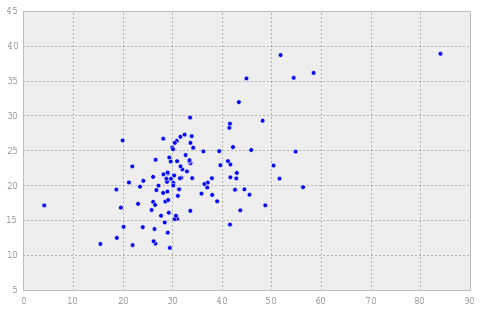

In [173]:
data = dfo #.drop(['048', '049', '055'])

plt.figure(figsize=(8,5))
plt.scatter(data['isip8_sq2dev_mean_sqrt'], data['isip5_sq2dev_mean_sqrt'])
plt.show()

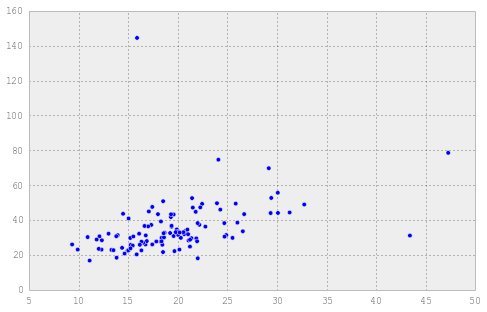

In [174]:
plt.figure(figsize=(8,5))
plt.scatter(dfo['isip5_ints_pstd'], dfo['isip8_ints_pstd'])
plt.show()

# Testing / visualizing - not needed in final 'product'

### Plotting interval results after filtering steps

In [175]:
def scatter_tooltips(df, x_col, y_col, 
                 size_col=None, 
                 color_col=None, 
                 show_all_cols=False,
                 fig_size=(8, 5)):
    #import matplotlib.pyplot as plt
    #import numpy as np
    import pandas as pd
    import mpld3
    from mpld3 import plugins

    #x = df[x_col]
    #y = df[y_col]
    df_info = [x_col, y_col]
    #for arg in args:
    #    df_info.append(arg)

    # Define some CSS to control our custom labels
    css = """
    table { border-collapse: collapse; }
    th { color: #ffffff; background-color: #000000; }
    td { background-color: #cccccc; }
    table, th, td { font-family:Arial, Helvetica, sans-serif;
                    border: 1px solid black; text-align: right; }
    """

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_size)
    ax.grid(True, alpha=0.3)

    labels = []
    for row in df.iterrows():
        index, series = row
        pid = index
        label = pd.DataFrame(series)
        labels.append(str(label.to_html()))

    points = ax.plot(df[x_col], 
                     df[y_col], 
                     'o', 
                     color='b',
                     markeredgecolor='k', 
                     markersize=8, 
                     markeredgewidth=1, 
                     alpha=.6)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(x_col + ' . ' + y_col, size=16)
    tooltip = plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    plugins.connect(fig, tooltip)

    return mpld3.display()


In [176]:
scatter_tooltips(data, 'isip8_sq2dev_mean_sqrt', 'isip5_sq2dev_mean_sqrt',
                 fig_size=(12, 7.5))

In [132]:
def d3plot(x, y, size=(10,6)):
    import mpld3

    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
    fig.set_size_inches((8,5) )
    scatter = ax.scatter(x, y,
                         #c=np.random.random(size=N),
                         s=40, #size
                         alpha=0.5,
                         cmap=plt.cm.jet)
    ax.grid(color='white', linestyle='solid')
    ax.set_title("Scatter Plot (with tooltips!)", size=10)
    labels = ['{0}'.format(pid) for pid in x.index]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)
    return mpld3.display()

In [133]:
d3plot(data['isip5_sq2devsum'], data['isip8_sq2devsum'])

#### intervals after filtering

050


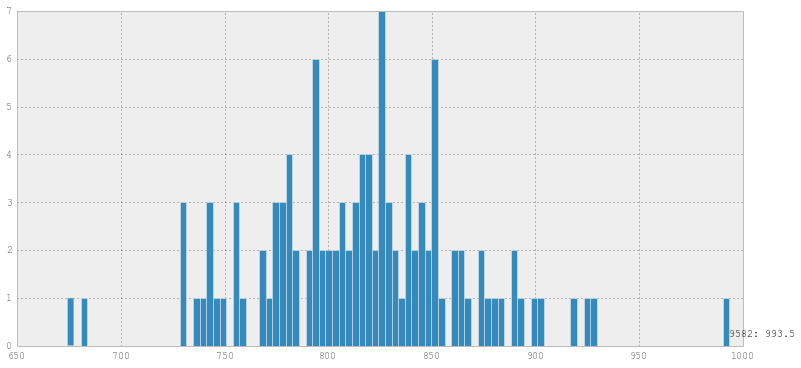

051


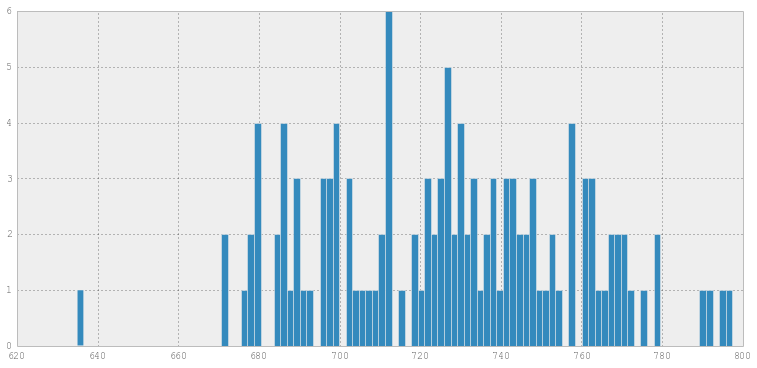

053


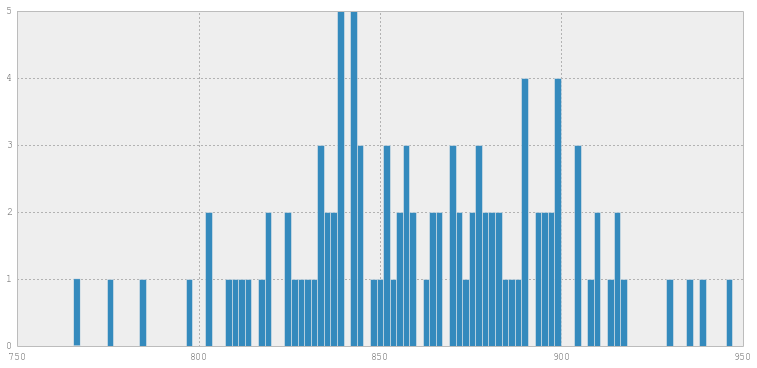

055


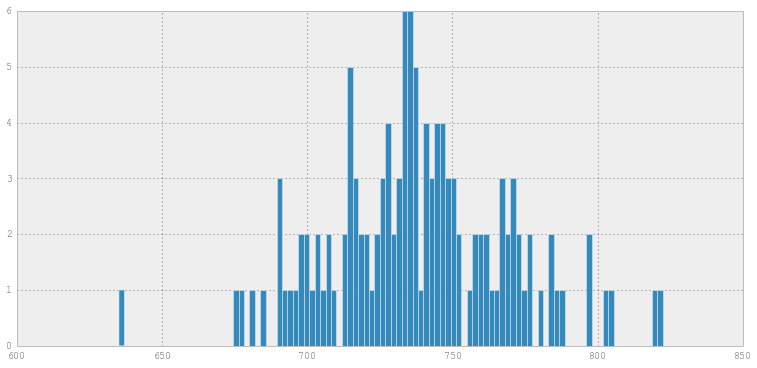

056


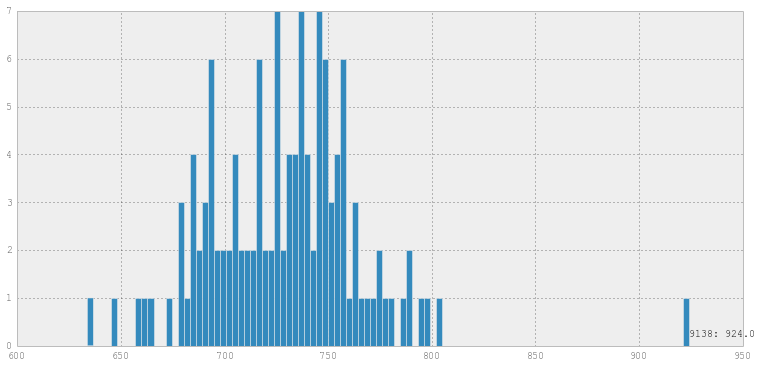

058


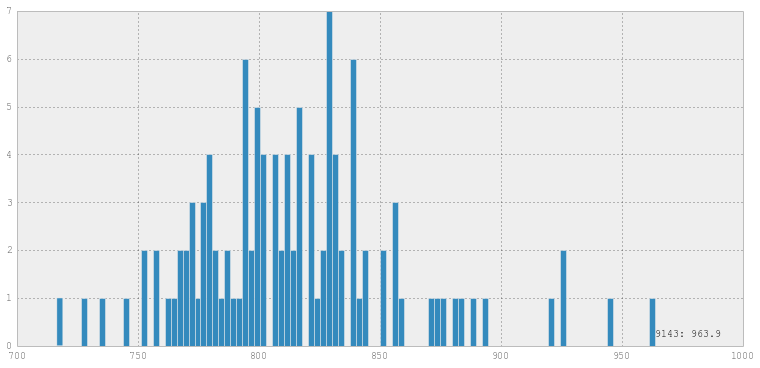

060


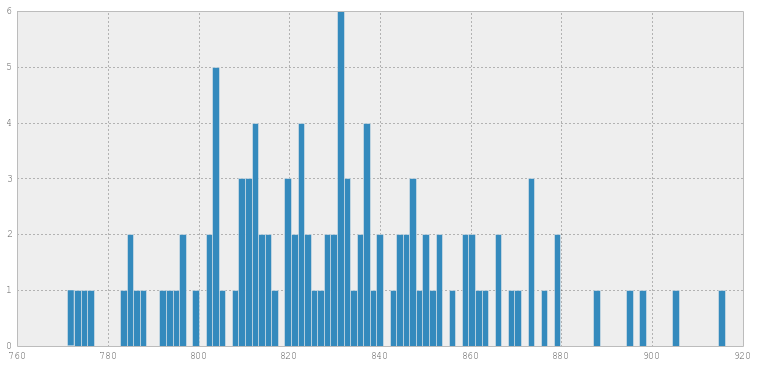

062


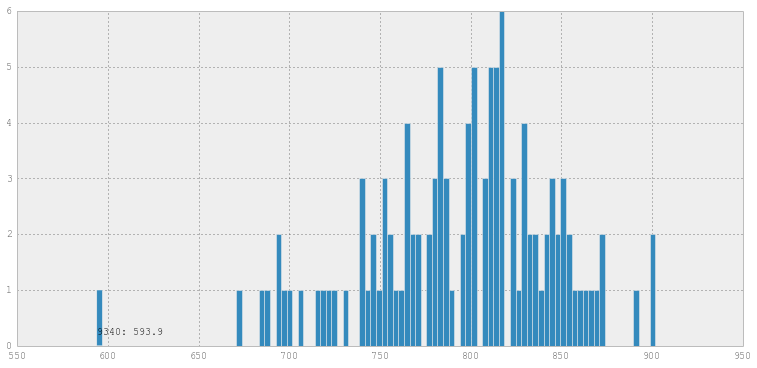

064


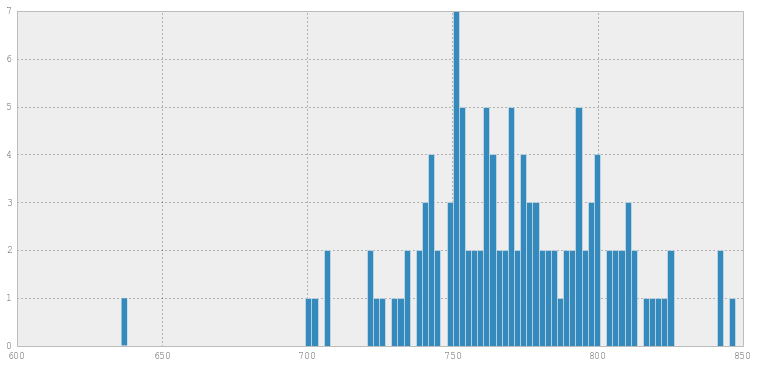

065


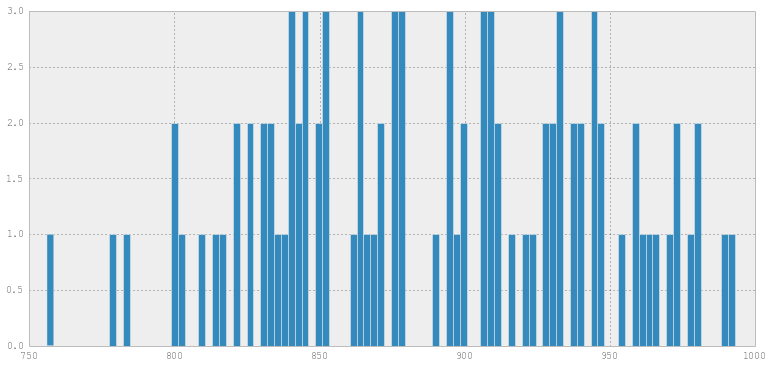

067


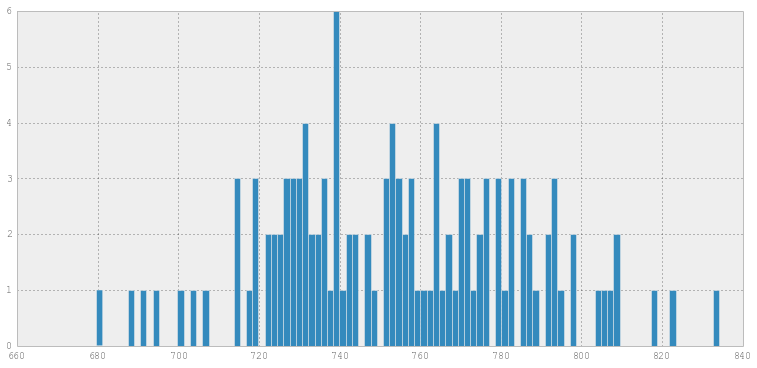

068


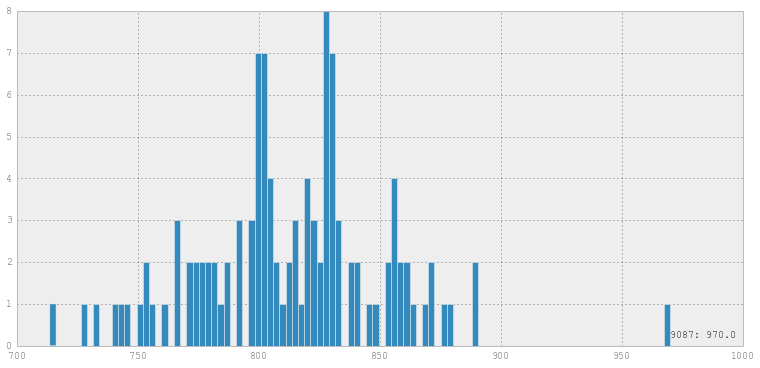

069


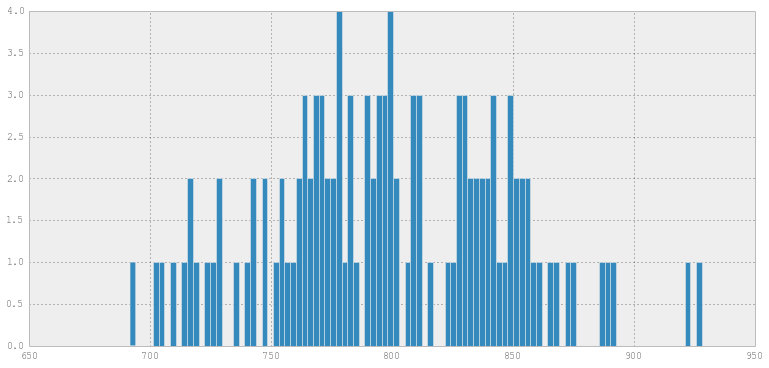

071


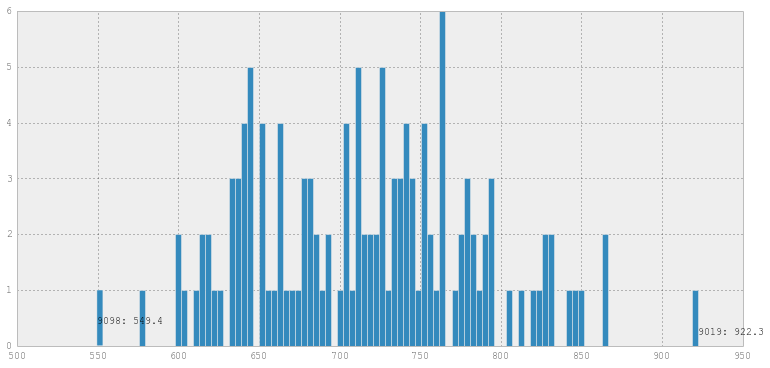

072


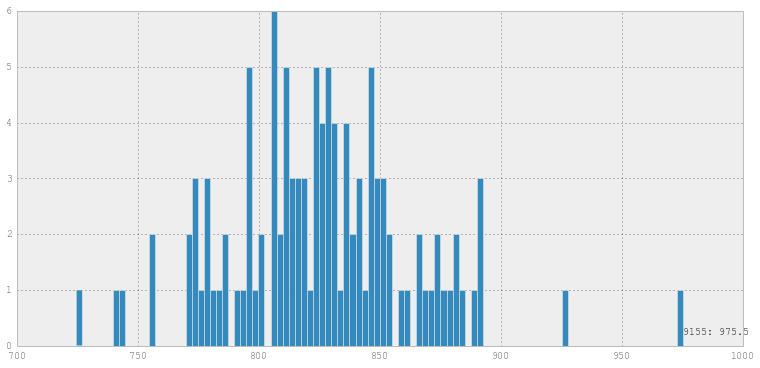

073


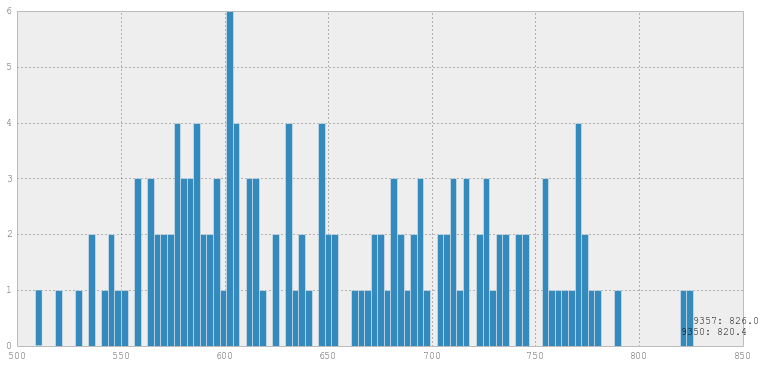

077


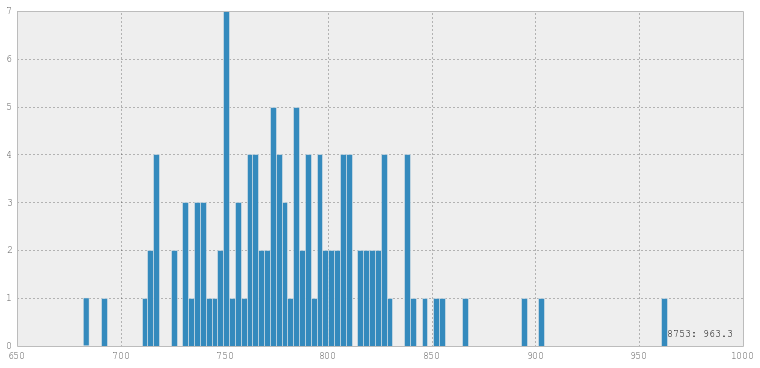

079


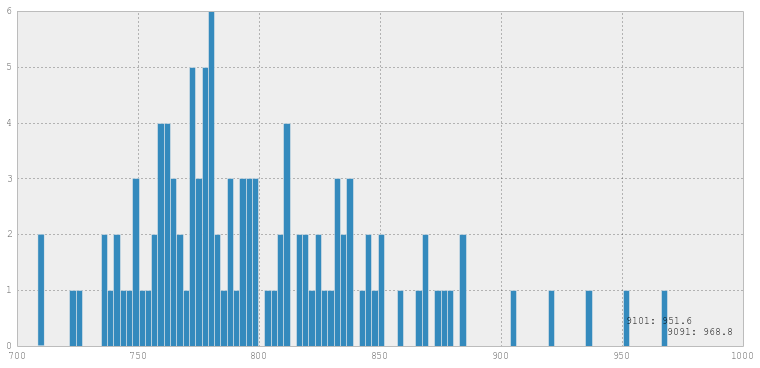

080


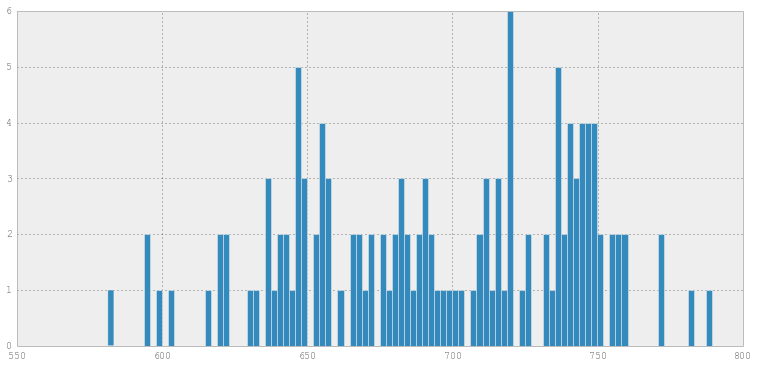

084


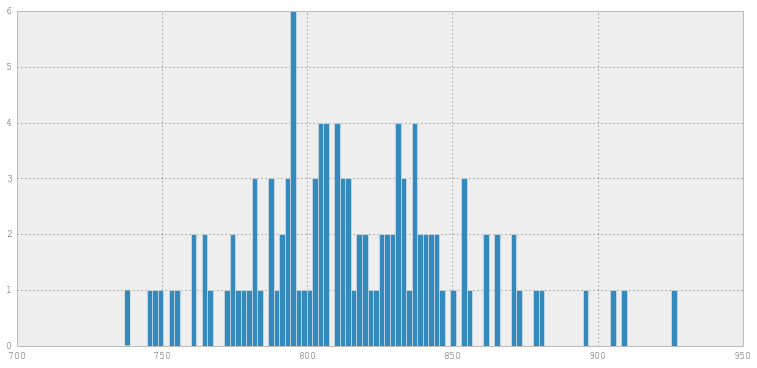

086


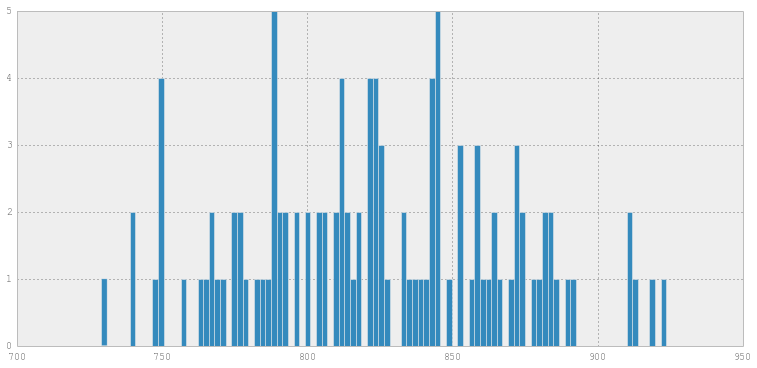

087


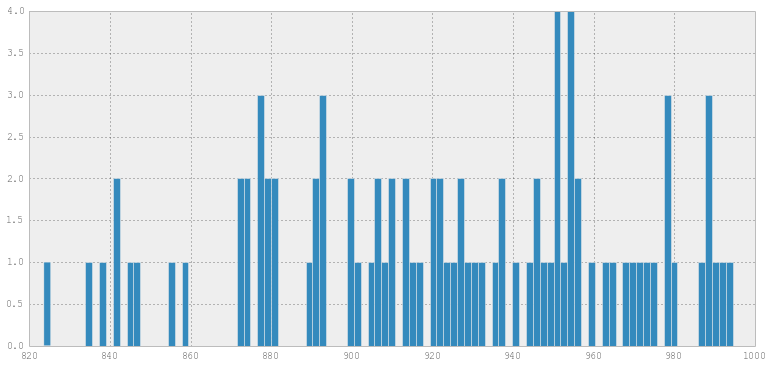

089


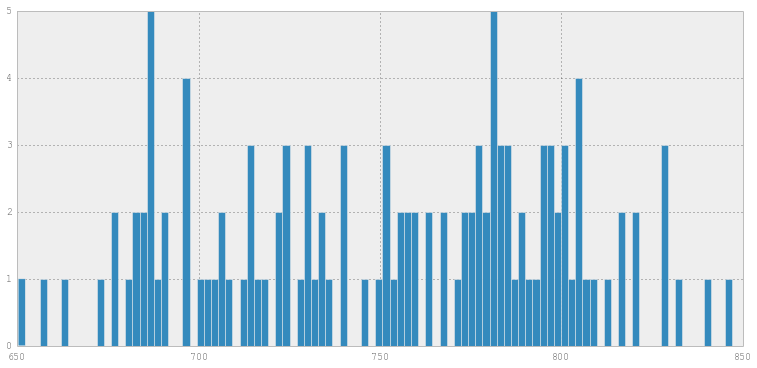

In [134]:
for pid in pid_list[40:80]:
    try:
        sset = db_isip8.xs([pid, 'tap_r'], level=['pid', 'stamp_type'])
        data = sset.ints
        if data.min() > 700 and data.max() < 900: continue        
        print(pid)
        plt.figure(figsize=(13,6))
        data.hist(bins=100)
        #annotating non-midpoint values
        caption_y_increment = 0.2
        median = data.median()
        prev_ypos = 0
        for idx, value in enumerate(data):
            if np.abs(value - median) > 150:
                caption = str(data.index[idx]) + ": " + str(value.round(1))
                plt.annotate(caption, (value, prev_ypos + caption_y_increment))
                prev_ypos += caption_y_increment
        plt.show()
    except:
        print("error....")


#p056: high outlier at 9138: 924.0 ms  ***
#045, 046: error or no data

#need lower bound of >632 for participant 048 (extra long intervals from explicit midpoint counting)

#p. 064: low outlier at about 630-640ms


In [26]:
sset = db_isip8.xs(['056', 'tap_r'], level=['pid', 'stamp_type'])
print(sset.ints.mean())
print(sset.ints.std())


728.982048
37.2019991333


049


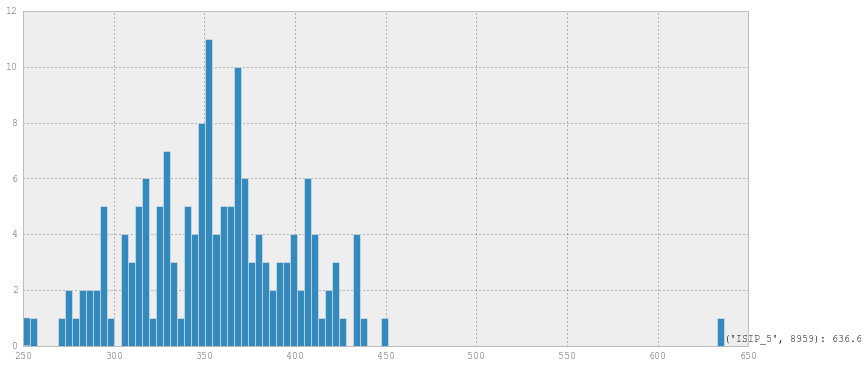

055


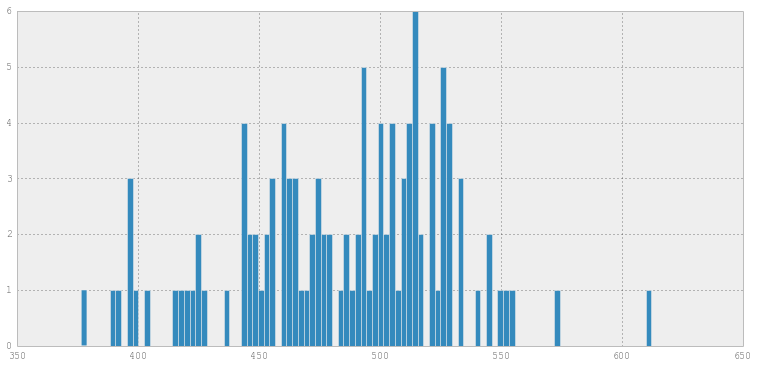

In [18]:
for pid in pid_list:
    try:
        sset = db_isip5.xs([pid, 'tap_r'], level=['pid', 'stamp_type'])
        data = sset.ints
        if data.min() > 400 or data.max() < 600: continue        
        print(pid)
        plt.figure(figsize=(13,6))
        data.hist(bins=100)
        #annotating non-midpoint values
        caption_y_increment = 0.2
        median = data.median()
        prev_ypos = 0
        for idx, value in enumerate(data):
            if np.abs(value - median) > 150:
                caption = str(data.index[idx]) + ": " + str(value.round(1))
                plt.annotate(caption, (value, prev_ypos + caption_y_increment))
                prev_ypos += caption_y_increment
        plt.show()
    except:
        print("error....")

#High outliers:
#p049 - will need to remove manually

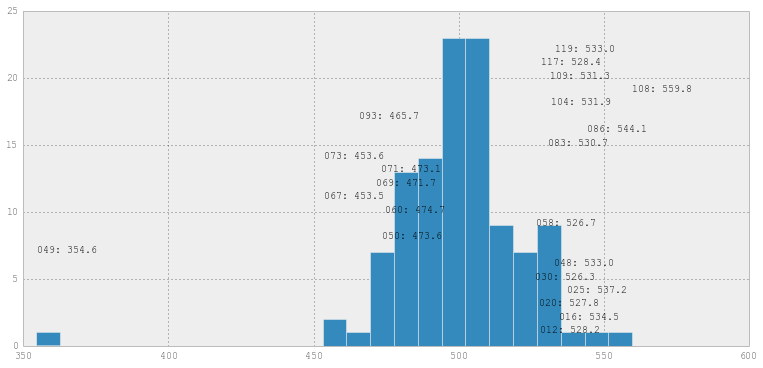

In [99]:
taps = db_isip5.xs('tap_r', level='stamp_type').ints
pmeans = taps.groupby(level='pid').mean()

data = pmeans

##############################

plt.figure(figsize=(13,6))
data.hist(bins=25)

#annotating non-midpoint values
caption_y_increment = 1
median = data.median()
prev_ypos = 0
for idx, value in enumerate(data):
    if np.abs(value - median) > 25:
        caption = str(data.index[idx]) + ": " + str(value.round(1))
        plt.annotate(caption, (value, prev_ypos + caption_y_increment))
        prev_ypos += caption_y_increment
plt.show()

#why is pid 049's mean so low?

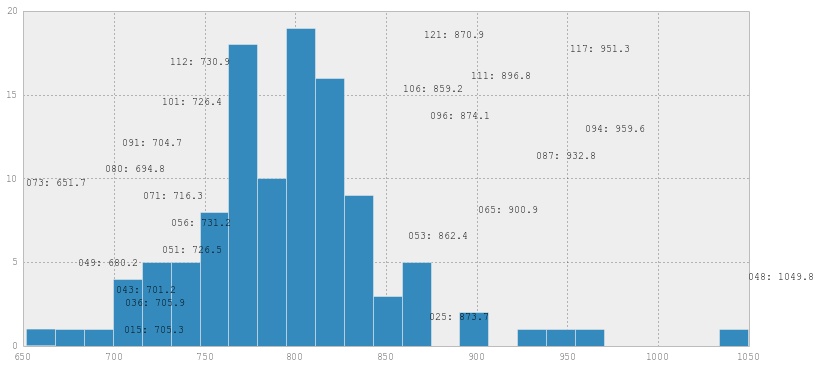

In [98]:
taps = db_isip8.xs('tap_r', level='stamp_type').ints
pmeans = taps.groupby(level='pid').mean()

data = pmeans

##############################

plt.figure(figsize=(13,6))
data.hist(bins=25)

#annotating non-midpoint values
caption_y_increment = 0.8
median = data.median()
prev_ypos = 0
for idx, value in enumerate(data):
    if np.abs(value - median) > 60:
        caption = str(data.index[idx]) + ": " + str(value.round(1))
        plt.annotate(caption, (value, prev_ypos + caption_y_increment))
        prev_ypos += caption_y_increment
plt.show()

#Good distribution-- 048 is a bit high